In [1]:
#Going to take in the first part of quick_scripy.py to to tomography tries
import make_discrete_vdf as mdv
import numpy as np
import matplotlib.pyplot as plt
from fancy_plot import fancy_plot
from multiprocessing import Pool
import time
from scipy.optimize import curve_fit



In [2]:
#Gaussian
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


In [3]:
#Parallel Processing of integration
def proc_wrap(arg):
    return [mdv.arb_p_response(*arg[:-1]),arg[-1]]

In [4]:
#set up initial plasma parameters
pls_par = np.array([-580., 100., -10., 10., 80., 15.])

In [5]:
#Set up magnetic field vector normal vector
mag_par = np.array([np.cos(np.radians(75.))*np.cos(.1), np.sin(np.radians(75.))*np.cos(.1), np.sin(.1)])
#verify it goes to 1.
print(np.sqrt(np.sum(mag_par**2)))

1.0


In [6]:
#number of sample for mid-point integration
samp = 4.5e1

In [7]:
#make a discrete VDF given plasma parameters and magnetic field parameters
dis_vdf = mdv.make_discrete_vdf(pls_par,mag_par,pres=1.00,qres=1.00,clip=4.)

In [8]:
#get random angles of faraday cup in phi and theta
#number of fc cups
ncup = 20
#set random seed for FC angles
np.random.seed(1107)

#Get two uniform number between -30 and 30
phis = np.random.uniform(-30.,30.,size=ncup)
thetas = np.random.uniform(-30.,30.,size=ncup)

In [9]:
#veloity grid
#########################################
######################################
#grid_v = np.arange(450,790,20)
v_mag = np.sqrt(np.sum(pls_par**2))
grid_v = np.arange(v_mag-150,v_mag+150,20)

In [10]:
#get effective area of wind and other coversion parameters from 
waeff = 3.8e6 #cm^3/km
q0    = 1.6021892e-7 # picocoulombs
dv    = np.diff(grid_v) #km/s
dv    = np.concatenate([dv,[dv[-1]]]) #km/s
cont  = 1.e12/(waeff*q0*dv*grid_v) #particle per cc per km/s

In [11]:
#number of processes to use per calculation
nproc = 8

In [30]:
#array that store all the fit parameters 
big_arr = []

#calculate the "real measured reduced response function" for all fc cups
fcs = {}
for k,(phi,theta) in enumerate(zip(phis,thetas)):
    #calculate x_meas array
    x_meas = mdv.make_fc_meas(dis_vdf,fc_spd=grid_v,fc_phi=phi,fc_theta=theta)
    #compute the observed current in the instrument
    rea_cur = mdv.arb_p_response(x_meas,dis_vdf,samp)

    #create key for input fc
    key = 'fc_{0:1d}'.format(k)
    fcs[key] = {}

    #populate key with measurements and parameter 
    fcs[key]['x_meas']  = x_meas
    fcs[key]['rea_cur'] = rea_cur

    #calculate the Gaussian fit of the response
    popt, pcov = curve_fit(gaus,grid_v,rea_cur*cont,p0=[np.nanmax(rea_cur*cont),np.mean(grid_v),np.sqrt(2.*np.log(2))*2*dv[0]],sigma=1./(rea_cur/rea_cur.min()),maxfev=1000)


    #Switched to computing the average
    #####get the parameters from the fit
    u = popt[1] #speed in km/s
    w = np.abs(popt[2]*np.sqrt(2.)) #thermal speed in km/s
    n = popt[0]*w*np.sqrt(np.pi) #density in cc

    #Add fit parameters with velocity guesses
    big_arr.append([u,w,n,phi,theta])



In [31]:
#convert big_arr intop numpy array
big_arr = np.array(big_arr)

In [32]:
#get speed solution per observatory
v_angl = big_arr[:,0]
#thermal speed in GSE
w_angl = big_arr[:,1]
#get the density to compute the magnitude
n_angl = big_arr[:,2]

#Get rotation matrix between GSE and the magnetic field parameters
rot_mat = mdv.euler_angles(np.arctan2(mag_par[1],mag_par[0]),np.arcsin(mag_par[2]),psi_ang=0.)

In [33]:
#get v_gse solution (Produces the same solution as the Wind spacecraft solution)
#in /crater/observatories/wind/code/dvapbimax/sub_bimax_moments.pro
vx,vy,vz =  mdv.compute_gse_from_fit(np.radians(phis),np.radians(thetas),v_angl) #np.dot(np.dot(np.dot(v_svdc.T,wp_svdc),u_svdc.T),v_angl)
wv =  mdv.compute_gse_from_fit(np.radians(phis),np.radians(thetas),w_angl) #np.dot(np.dot(np.dot(v_svdc.T,wp_svdc),u_svdc.T),v_angl)
nv =  mdv.compute_gse_from_fit(np.radians(phis),np.radians(thetas),n_angl)



In [34]:
#compute density
n = np.sqrt(np.sum(nv**2))

In [35]:
#compute Wpar (wa) and Wper (we)
#Use Theta and phi angles between Vgse and Bnorm to get the new vectors
wa = np.abs(rot_mat.dot(wv)[0])
we = np.sqrt(np.linalg.norm(wv)**2-wa**2)


In [36]:
#make a discrete VDF with the incorrect parameters but the same grid
pls_par_bad = np.array([vx, vy, vz,we,wa,n])
print('Input')
print(pls_par)
print('SVD Guess')
print(pls_par_bad)

Input
[-580.  100.  -10.   10.   80.   15.]
SVD Guess
[-580.47658862  103.43175203  -11.06991855   20.70925313   54.04426653
   14.90459929]


In [59]:
#First due dummy easy case with Radon and inverse radon projections
from skimage.transform import iradon, radon
rad_theta = np.linspace(0., 180., max(dis_vdf['vdf'].shape), endpoint=False)
sinogram = radon(dis_vdf['vdf'], theta=rad_theta, circle=False)


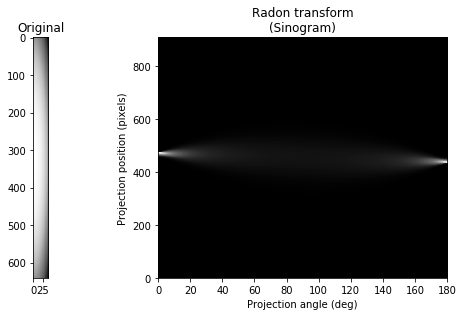

In [63]:
#plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(np.log10(dis_vdf['vdf']), cmap=plt.cm.Greys_r)

ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

fig.tight_layout()
plt.show()

In [60]:
#Use inverse Radon transformation to reconstruct the image
reconstruction = iradon(sinogram, theta=rad_theta, circle=True)



/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


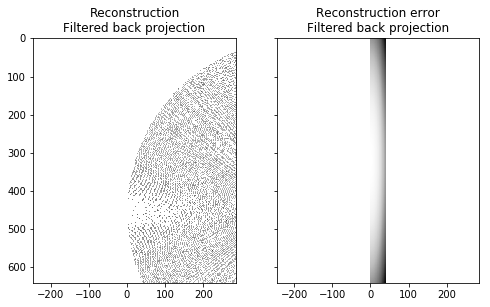

In [61]:
#plot the differences
#error = reconstruction - dis_vdf['vdf']
#print('FBP rms reconstruction error: %.3g' % np.sqrt(np.mean(error**2)))

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(np.log10(reconstruction), cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(np.log10(dis_vdf['vdf']), cmap=plt.cm.Greys_r)
plt.show()